In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import glob
from torchvision import transforms, models, datasets
from torchvision.ops import nms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('../input/self-driving-cars/labels_train.csv')
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [5]:
df['xmin'].loc[(df['xmin'] == 0)] = 1
df['ymin'].loc[(df['ymin'] == 0)] = 1
df['xmax'].loc[(df['xmax'] == 0)] = 1
df['ymax'].loc[(df['ymax'] == 0)] = 1

In [6]:
df = df[:60000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   frame     60000 non-null  object
 1   xmin      60000 non-null  int64 
 2   xmax      60000 non-null  int64 
 3   ymin      60000 non-null  int64 
 4   ymax      60000 non-null  int64 
 5   class_id  60000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.7+ MB


In [7]:
!pwd

/kaggle/working


In [8]:
import os
import inspect
import numpy as np
from PIL import Image
def new_df(df):
    for (i, fname) in list(enumerate(df.frame.values)):
        fpath = f'../input/self-driving-cars/images/{fname}'
        img = np.asarray(Image.open(fpath))
        h ,w ,_ = img.shape
        df['xmin'].iloc[i] = df['xmin'].iloc[i]/w
        df['xmax'].iloc[i] = df['xmax'].iloc[i]/w
        df['ymin'].iloc[i] = df['ymin'].iloc[i]/h
        df['ymax'].iloc[i] = df['ymax'].iloc[i]/h
    return df 
df1 = new_df(df)
df1.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,0.493750,0.522917,0.476667,0.516667,1
1,1478019952686311006.jpg,0.910417,0.945833,0.400000,0.620000,3
2,1478019953180167674.jpg,0.454167,0.481250,0.486667,0.526667,1
3,1478019953689774621.jpg,0.356250,0.379167,0.470000,0.513333,2
4,1478019953689774621.jpg,0.372917,0.397917,0.480000,0.516667,1


In [9]:
df1 = df1[df1['xmin']>=0.1]
df1 = df1[df1['xmax']>=0.1]
df1 = df1[df1['ymin']>=0.1]
df1 = df1[df1['ymax']>=0.1]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53633 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   frame     53633 non-null  object 
 1   xmin      53633 non-null  float64
 2   xmax      53633 non-null  float64
 3   ymin      53633 non-null  float64
 4   ymax      53633 non-null  float64
 5   class_id  53633 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.9+ MB


In [10]:
df.describe()


,xmin,xmax,ymin,ymax,class_id
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.419181,0.486135,0.435589,0.531057,2.064300
std,0.230560,0.232526,0.087357,0.111078,1.620188
min,0.002083,0.012500,0.003333,0.043333,1.000000
25%,0.243750,0.310417,0.416667,0.506667,1.000000
50%,0.418750,0.466667,0.463333,0.543333,1.000000
75%,0.577083,0.639583,0.486667,0.576667,3.000000
max,0.987500,0.997917,0.690000,0.996667,5.000000


In [11]:
df1.describe()

,xmin,xmax,ymin,ymax,class_id
count,53633.000000,53633.000000,53633.000000,53633.000000,53633.000000
mean,0.456546,0.519592,0.439753,0.529769,2.065035
std,0.203784,0.211894,0.073242,0.101069,1.627243
min,0.100000,0.112500,0.100000,0.153333,1.000000
25%,0.297917,0.358333,0.420000,0.503333,1.000000
50%,0.447917,0.493750,0.463333,0.540000,1.000000
75%,0.591667,0.658333,0.483333,0.573333,3.000000
max,0.987500,0.997917,0.690000,0.996667,5.000000


In [12]:
df1.columns

Index(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], dtype='object')

In [13]:
print(f"Number of rows in df1: {len(df1), df1}")

Number of rows in df1: (53633,                          frame      xmin      xmax      ymin      ymax  \
0      1478019952686311006.jpg  0.493750  0.522917  0.476667  0.516667   
1      1478019952686311006.jpg  0.910417  0.945833  0.400000  0.620000   
2      1478019953180167674.jpg  0.454167  0.481250  0.486667  0.526667   
3      1478019953689774621.jpg  0.356250  0.379167  0.470000  0.513333   
4      1478019953689774621.jpg  0.372917  0.397917  0.480000  0.516667   
...                        ...       ...       ...       ...       ...   
59995  1478898607956958507.jpg  0.318750  0.508333  0.293333  0.670000   
59996  1478898607956958507.jpg  0.552083  0.806250  0.523333  0.653333   
59997  1478898607956958507.jpg  0.850000  0.877083  0.500000  0.633333   
59998  1478898608528676596.jpg  0.164583  0.229167  0.510000  0.596667   
59999  1478898608528676596.jpg  0.227083  0.279167  0.523333  0.583333   

       class_id  
0             1  
1             3  
2             1  
3       

In [14]:
labels = { 0:'backgroud',
          1:'car',
          2:'truck',
          3:'pedestrian',
          4:'bicyclist',
          5:'light'}
target2labels = labels.copy()
target2labels

{0: 'backgroud',
 1: 'car',
 2: 'truck',
 3: 'pedestrian',
 4: 'bicyclist',
 5: 'light'}

In [15]:
num_classes = len(labels)
num_classes

6

In [16]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Note: you may need to restart the kernel to use updated packages.


In [17]:
!pip install opencv-python

In [18]:
if not os.path.exists('../input/self-driving-cars/images/1478019952686311006.jpg'):
    raise FileNotFoundError('Image file not found')

In [19]:
!pip install ultralytics
!pip install opencv-python-headless==4.8.1.78
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 603.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80


(224, 224, 3)


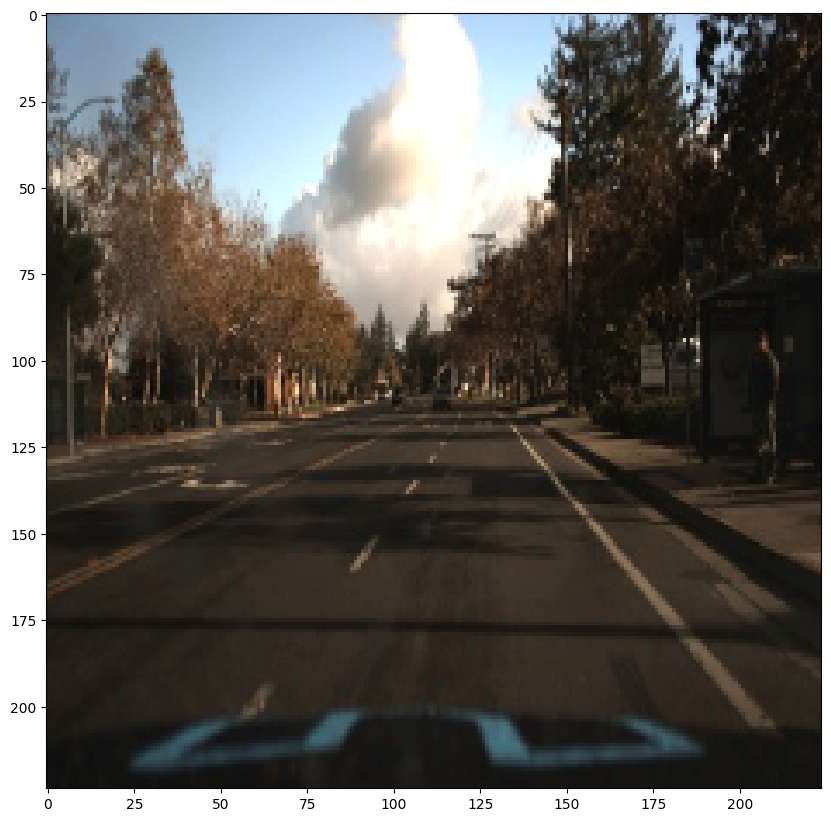

In [20]:
import os
import PIL
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('../input/self-driving-cars/images/1478019952686311006.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img , (224,224))
plt.figure(figsize=(10,13))
plt.imshow(img)
print(img.shape)

In [21]:
h , w , _ = img.shape
h ,w

(224, 224)

In [22]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [23]:
print(f"Number of rows in df1: {len(df1)}")

Number of rows in df1: 53633


In [24]:
import glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SelfDrivingCarDataset(Dataset):
    w, h = 224, 224
    
    def __init__(self, df, image_root_dir='../input/self-driving-cars/images'):
        self.image_dir = image_root_dir
        self.df = df
        self.files = glob.glob(self.image_dir + '/*.jpg')
        self.image_infos = df.frame.unique()

    def __len__(self):
        return len(self.image_infos)

    def __getitem__(self, ix):
        img_id = self.image_infos[ix]
        img_path = f'../input/self-driving-cars/images/{img_id}'
        img = Image.open(img_path).convert('RGB')
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR)) / 255.
        data = self.df[self.df['frame'] == img_id]
        labels = data['class_id'].values.tolist()
        data = data[['xmin', 'ymin', 'xmax', 'ymax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([i for i in labels]).long()
        img = preprocess_image(img)
        return img, target 

    def collate_fn(self, batch):
        return tuple(zip(*batch))

# Assuming df1 is your dataframe
trn_ids, val_ids = train_test_split(df1.frame.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df1[df1['frame'].isin(trn_ids)], df1[df1['frame'].isin(val_ids)]

train_ds = SelfDrivingCarDataset(trn_df)
val_ds = SelfDrivingCarDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=4, collate_fn=val_ds.collate_fn, drop_last=True)

In [25]:
len(train_ds) , len(val_ds)

(7538, 838)

In [26]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained =True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor( in_features , num_classes )
  return model

In [27]:
def train_batch(inputs, model , optimizer):
  model.train()
  input , targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()
  return loss , losses

@torch.no_grad()
def validate_batch(inputs, models):
  model.train()
  input , targets = inputs
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  return loss ,losses

In [28]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters() , lr=0.005 , momentum = 0.9 , weight_decay= 0.0005 )
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 156MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Model Training

In [29]:
loss_criterions = ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']
EPOCHS = 5

In [30]:
import time
start = time.time()
tcl , trl , tol , trpnl ,ttl = [] ,[] ,[] ,[] ,[]
vcl , vrl , vol , vrpnl ,vtl = [] ,[] ,[] ,[] ,[]
for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  tecl , terl , teol , terpnl ,tetl = [] ,[] ,[] ,[] ,[]
  vecl , verl , veol , verpnl ,vetl = [] ,[] ,[] ,[] ,[]
  for ix , batch in enumerate(train_loader):
    loss , losses = train_batch(batch , model , optimizer )
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    tecl.append(los_loss.detach().cpu().numpy()) , terl.append(reg_loss.detach().cpu().numpy()) , teol.append(loss_obj.detach().cpu().numpy())
    terpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,tetl.append(tot_loss.detach().cpu().numpy())
    if ix%60 == 0 and ix!=0:
        print(f'{ix} batches completed')
  print(f'Training - Total Loss {np.mean(tetl):.5f} | Classification Loss {np.mean(tecl):.5f} | Regression Loss {np.mean(terl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(teol):.5f} | RPN Loss {np.mean(terpnl):.5f}' )
  tcl.append(np.mean(tecl)) , trl.append(np.mean(terl)) , tol.append(np.mean(teol)) , trpnl.append(np.mean(terpnl)) ,ttl.append(np.mean(tetl))


  for ix , batch in enumerate(val_loader):
    loss , losses = validate_batch(batch ,model )
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    vecl.append(los_loss.detach().cpu().numpy()) , verl.append(reg_loss.detach().cpu().numpy()) , veol.append(loss_obj.detach().cpu().numpy())
    verpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,vetl.append(tot_loss.detach().cpu().numpy())

  print(f'Validation - Total Loss {np.mean(vetl):.5f} | Classification Loss {np.mean(vecl):.5f} | Regression Loss {np.mean(verl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(veol):.5f} | RPN Loss {np.mean(verpnl):.5f}' )

  vcl.append(np.mean(vecl)) , vrl.append(np.mean(verl)) , vol.append(np.mean(veol)) , vrpnl.append(np.mean(verpnl)) ,vtl.append(np.mean(vetl))

  print('===============================================================================Done')
  print()
print('                    ****************** Training Completed *****************                             ')
end = time.time()
total_time = end-start

EPOCH 1
60 batches completed
120 batches completed
180 batches completed
240 batches completed
300 batches completed
360 batches completed
420 batches completed
480 batches completed
540 batches completed
600 batches completed
660 batches completed
720 batches completed
780 batches completed
840 batches completed
900 batches completed
960 batches completed
1020 batches completed
1080 batches completed
1140 batches completed
1200 batches completed
1260 batches completed
1320 batches completed
1380 batches completed
1440 batches completed
1500 batches completed
1560 batches completed
1620 batches completed
1680 batches completed
1740 batches completed
1800 batches completed
1860 batches completed
Training - Total Loss 0.60065 | Classification Loss 0.20102 | Regression Loss 0.32583  | Object Loss 0.03965 | RPN Loss 0.03414
Validation - Total Loss 0.65856 | Classification Loss 0.23471 | Regression Loss 0.34168  | Object Loss 0.04620 | RPN Loss 0.03596
======================================

In [31]:
print(f'Total Time Taken : {total_time} seconds')

Total Time Taken : 7977.63306927681 seconds


Visual Representation

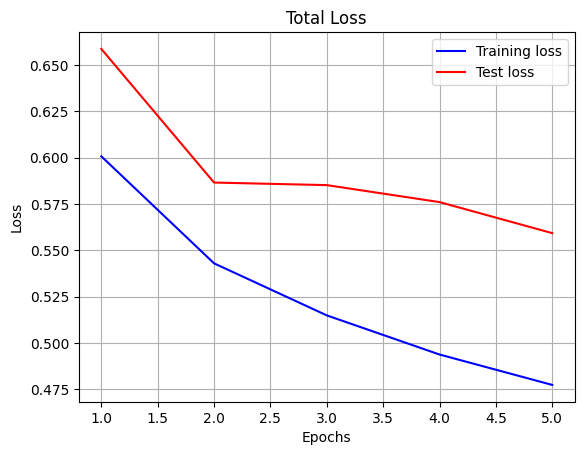

In [32]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
def plot_pf(tl , vl , head):
    plt.plot(epochs, tl, 'b', label='Training loss')
    plt.plot(epochs, vl , 'r', label='Test loss')
    plt.title(head)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()
plot_pf(ttl ,vtl , "Total Loss")

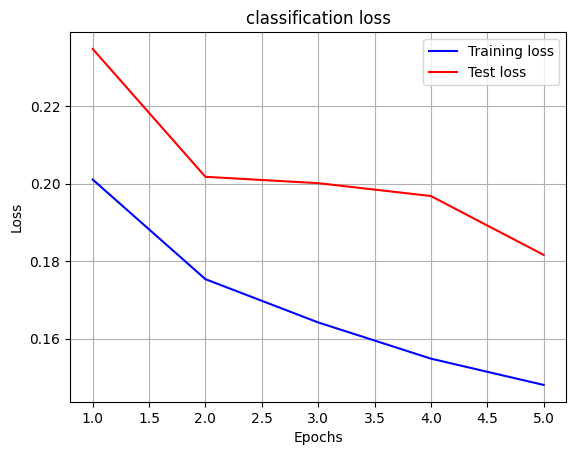

In [33]:
plot_pf(tcl , vcl ,'classification loss')

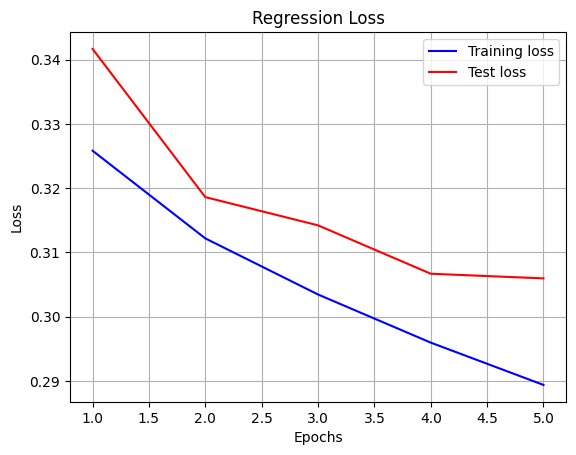

In [34]:
plot_pf(trl , vrl , "Regression Loss")

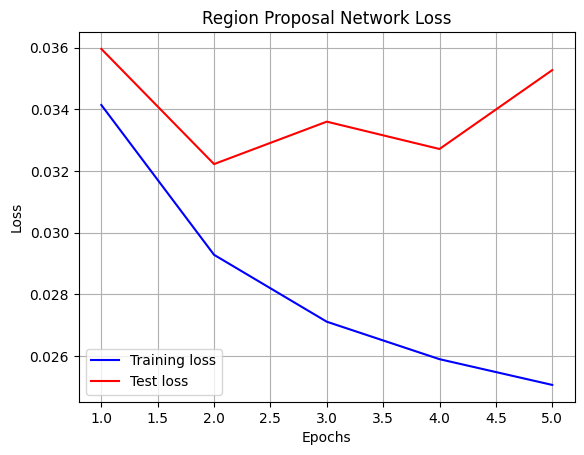

In [35]:
plot_pf(trpnl, vrpnl , "Region Proposal Network Loss")

**Evaluation, Testing & Results**

In [36]:
print(f'''tcl = {tcl}
      trl = {trl}
      tol = {tol}
      trpnl = {trpnl}
      ttl = {ttl}''')

tcl = [0.20102304, 0.17533845, 0.16418658, 0.1548484, 0.14807019]
      trl = [0.3258296, 0.31217894, 0.30344224, 0.29594666, 0.28936058]
      tol = [0.039650496, 0.026142983, 0.020144718, 0.017088186, 0.014889794]
      trpnl = [0.034144413, 0.029281916, 0.027110709, 0.025895152, 0.025059672]
      ttl = [0.60064757, 0.5429423, 0.51488423, 0.49377844, 0.47738022]


In [37]:
print(f'''vcl = {vcl}
      vrl = {vrl}
      vol = {vol}
      vrpnl = {vrpnl}
      vtl = {vtl}''')

vcl = [0.23471475, 0.2017375, 0.20009886, 0.19677761, 0.18160518]
      vrl = [0.34168166, 0.3186038, 0.3142096, 0.30667338, 0.30594945]
      vol = [0.046200816, 0.03393282, 0.03720929, 0.039800316, 0.03639847]
      vrpnl = [0.035963204, 0.03222626, 0.03360285, 0.03271586, 0.035275698]
      vtl = [0.65856045, 0.58650035, 0.5851206, 0.5759672, 0.5592288]


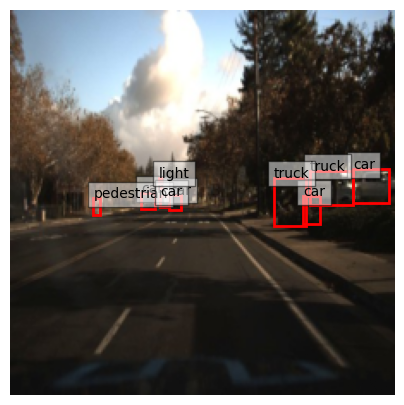

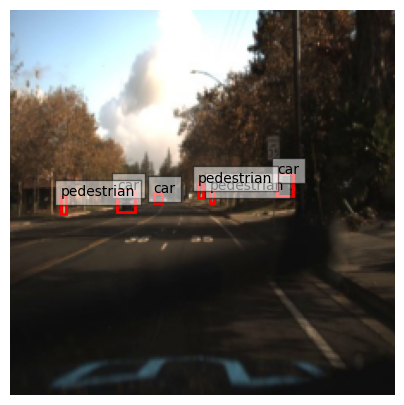

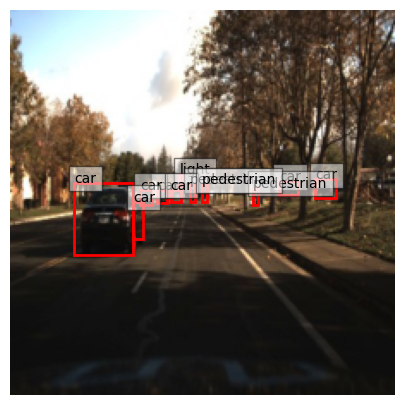

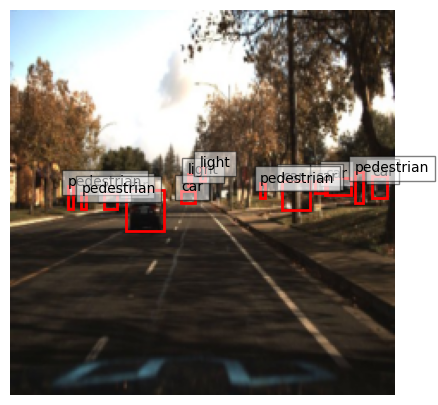

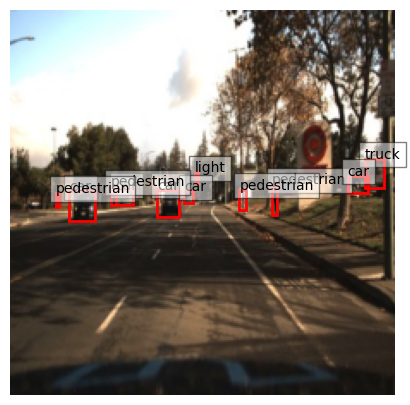

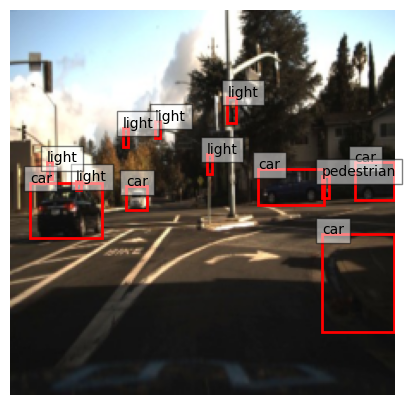

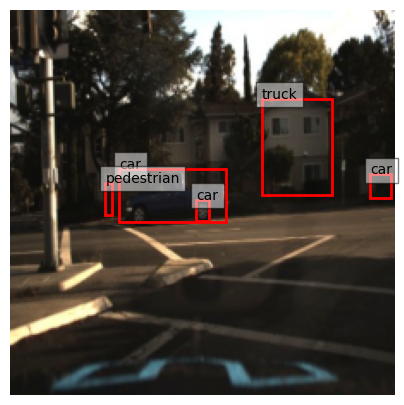

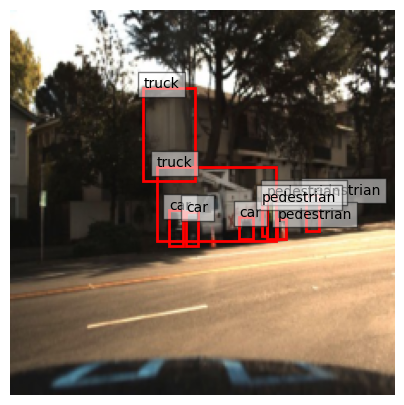

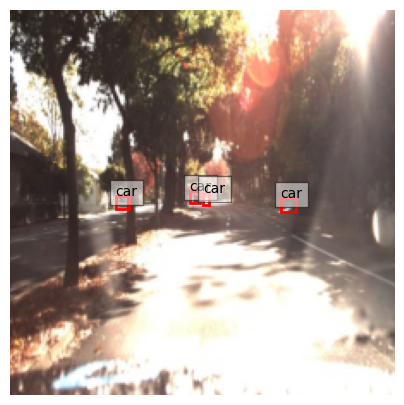

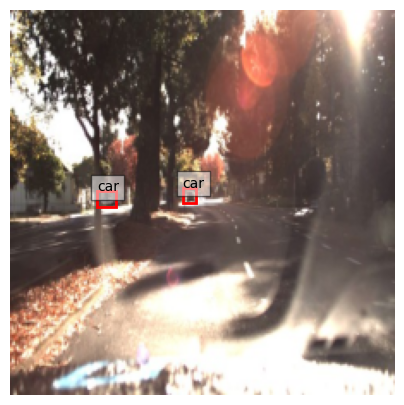

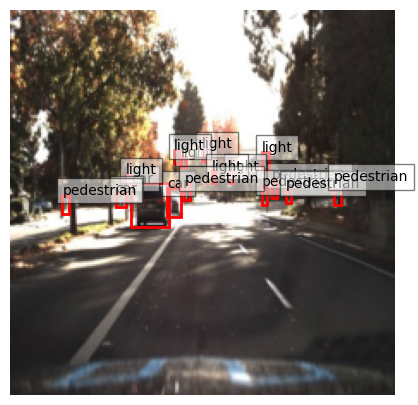

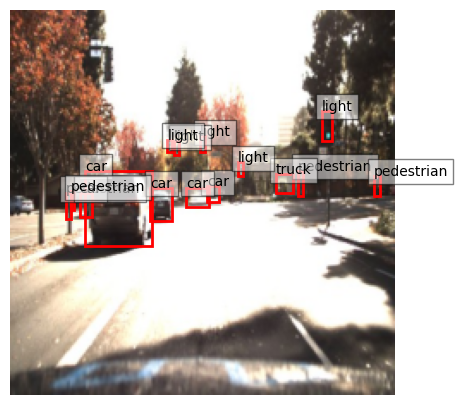

In [38]:
from torchvision.ops import nms

import matplotlib.pyplot as plt
import numpy as np

def show(image, bbs=[], texts=[], sz=5):
    plt.figure(figsize=(sz, sz))
    plt.imshow(image)
    ax = plt.gca()
    for bb, text in zip(bbs, texts):
        xmin, ymin, xmax, ymax = bb
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, text, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2labels[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    # print(outputs)
    for ix, output in enumerate(outputs):
       bbs, confs, labels = decode_output(output)
       info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
       show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [39]:
torch.save(model.to('cpu').state_dict(), './Self-Driving-Car-FRCNN-V0-5epochs.pth')